In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install albumentations==1.1.0 opencv-python==4.5.4.58 --quiet
!pip install timm --quiet

     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
     |████████████████████████████████| 376 kB 4.0 MB/s 


In [ ]:
import pandas as pd
import timm
from tqdm import tqdm
import numpy as np
import os
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2 as cv
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from scipy.special import softmax

In [ ]:
seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
data_path = os.path.join(os.getcwd(), 'drive/MyDrive/data_diploma/SFU/BlastsOnline/')
gt_icm_path = os.path.join(data_path, 'GT_ICM')
gt_te_path = os.path.join(data_path, 'GT_TE')
gt_zp_path = os.path.join(data_path, 'GT_ZP')
images_path = os.path.join(data_path, 'Images')
compound_gt_path = os.path.join(data_path, 'predicted_compound_gt')

In [ ]:
df = pd.read_excel(os.path.join(data_path, 'MasterlistAug30-2017.xlsx'), header=0)
df.drop(0, inplace=True)
df.drop([250, 251], inplace=True)
df.drop(['Unnamed: 0', 'Unnamed: 1', 'Acquisition Year'], axis=1, inplace=True)
df.tail()

,File Name,GRADE,Expansion,ICM,TE,Outcome
245,Blast_PCRM_d5.17,2BC,2.0,B,C,2.0
246,Blast_PCRM_d5.22,2AB,2.0,A,B,2.0
247,Blast_PCRM_d5.24,4AA,4.0,A,A,2.0
248,Blast_PCRM_d5.26,4BA,4.0,B,A,2.0
249,Blast_PCRM_d5.29,2BB,2.0,B,B,2.0


In [ ]:
image_filepaths = [os.path.join(images_path, d) for d in os.listdir(images_path)]
mask_filepaths = [os.path.join(compound_gt_path, d) for d in os.listdir(compound_gt_path)]

In [ ]:
path_pairs = list(zip(sorted(image_filepaths), sorted(mask_filepaths)))

for pair in path_pairs:
    img_name = os.path.basename(pair[0])[:-4]
    mask_name = os.path.basename(pair[1])[:-9]
    try:
        assert img_name == mask_name
    except AssertionError:
        print(img_name, mask_name, '\n****') # this is needed to make sure we formed path pairs in correct order (we've been burned before...)

In [ ]:
train_images_filepaths = path_pairs[:190]
val_images_filepaths = path_pairs[190:]

In [ ]:
img_name = os.path.basename(train_images_filepaths[0][0])[:-4]
a = df[df['File Name'] == img_name]['GRADE']
type(a.to_string())
df['GRADE'].unique()

array(['4AA', '3AB', '2AA', '3AA', '4AB', '3BB', '2BB', '4AC', '3BA',
       '2BA', '2AB', '4BB', '4BA', '2BC', '2CC', '2CB', '2AC', '3AC',
       '4CC', '4BC', '3BC'], dtype=object)

from unique values we infer range of classes.  
2-4 for Expansion  
A-C for ICM  
A-C for Trophectoderm

In [ ]:
train_transform = A.Compose([
                A.Resize(400, 400),
                A.Flip(),
                A.ShiftScaleRotate(scale_limit=0),
                A.CoarseDropout(max_height=16, max_width=16),
                A.Normalize(mean=(0.5685, 0.0780, 0.1088, 0.1503), std=(0.1500, 0.2673, 0.3080, 0.3542)),
                ToTensorV2()
])
val_transform = A.Compose([
                A.Resize(400, 400),
                A.Normalize(mean=(0.5685, 0.0780, 0.1088, 0.1503), std=(0.1500, 0.2673, 0.3080, 0.3542)),
                ToTensorV2()
])

In [ ]:
class BlastDataset(Dataset):
    def __init__(self, filepaths, transform, labels=df):
        self.filepaths = filepaths
        self.transform = transform
        self.labels = df

    def decode_mask(self, mask):
        decoded_shape = (mask.shape[0], mask.shape[1], 3)
        decoded_image = np.zeros(shape=decoded_shape)
        for i in range(3):
            decoded_image[:, :, i][mask == i + 1] = 255
        return decoded_image

    def encode_label(self, label):
        expansion_to_id = {'2': 0, '3': 1, '4': 2}
        grade_to_id = {'A': 0, 'B': 1, 'C': 2}
        encoded_label = (expansion_to_id[label[0]], grade_to_id[label[1]], grade_to_id[label[2]])
        return torch.Tensor(encoded_label)

    def __getitem__(self, idx):

        image, mask = self.filepaths[idx]
        img_name = os.path.basename(image)[:-4]
        image = cv.imread(image, cv.IMREAD_GRAYSCALE) # image is grayscale - later we should test if adding color improves performace
        mask = cv.imread(mask, cv.IMREAD_GRAYSCALE)
        mask = self.decode_mask(mask) # h*w*3 !!!
        input = np.dstack((image, mask)) # h*w*4
        if self.transform is not None:
            transformed = self.transform(image=input)
            input = transformed['image']
        grade = self.labels[self.labels['File Name'] == img_name]['GRADE'].values[0]
        grade = self.encode_label(grade)
        return input, grade

    def __len__(self):
        return len(self.filepaths)

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
def calculate_accuracy(output, target):
    with torch.no_grad():
        accs = []
        for logits, labels in zip(output, target):
            preds = F.softmax(logits, dim=1).argmax(dim=1)
            acc = torch.true_divide(torch.sum(preds == labels), logits.size(0))
            accs.append(acc)
        return accs

In [ ]:
def train(train_loader, model, criterion1, criterion2, criterion3, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for images, labels in stream:
        if device.type == 'cuda':
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
        expansion, icm, troph = model(images)
        labels_expansion = labels[:, 0]
        labels_icm = labels[:, 1]
        labels_troph = labels[:, 2]
        loss1 = criterion1(expansion, labels_expansion.long())
        loss2 = criterion2(icm, labels_icm.long())
        loss3 = criterion3(troph, labels_troph.long())
        loss = loss1 + loss2 + loss3
        acc_exp, acc_icm, acc_troph = calculate_accuracy((expansion, icm, troph), (labels_expansion, labels_icm, labels_troph))
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update('Accuracy_exp', acc_exp.item())
        metric_monitor.update('Accuracy_icm', acc_icm.item())
        metric_monitor.update('Accuracy_troph', acc_troph.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.           {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return [metric_monitor.metrics[metric]['avg'] for metric in metric_monitor.metrics.keys()]

In [ ]:
def validate(validation_loader, model, criterion1, criterion2, criterion3, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(validation_loader)
    with torch.no_grad():
        for images, labels in stream:
            if device.type == 'cuda':
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
            expansion, icm, troph = model(images)
            labels_expansion = labels[:, 0]
            labels_icm = labels[:, 1]
            labels_troph = labels[:, 2]
            loss1 = criterion1(expansion, labels_expansion.long())
            loss2 = criterion2(icm, labels_icm.long())
            loss3 = criterion3(troph, labels_troph.long())
            loss = loss1 + loss2 + loss3
            acc_exp, acc_icm, acc_troph = calculate_accuracy((expansion, icm, troph), (labels_expansion, labels_icm, labels_troph))
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update('Accuracy_exp', acc_exp.item())
            metric_monitor.update('Accuracy_icm', acc_icm.item())
            metric_monitor.update('Accuracy_troph', acc_troph.item())
            stream.set_description(
                "Epoch: {epoch}. Validation.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return [metric_monitor.metrics[metric]['avg'] for metric in metric_monitor.metrics.keys()]

In [ ]:
params = {
    "lr": 0.00005,
    "batch_size": 4,
    "num_workers": 2,
    "epochs": 20,
    "folds": 5
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} selected')

cuda selected


Docs for the xception are here:  
https://rwightman.github.io/pytorch-image-models/models/xception/  

We have to slightly modify the model, it will basically be a sandwich - first convolutions, then xception in all it's glory, then three separate fc classifiers. We sould pay attention to custom layer initialization.

In [ ]:
class CompositeModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.pre_trained = model
        self.pre_trained.conv1 = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.pre_trained.fc = nn.Identity() # 2048*1
        self.fc1 = nn.Linear(2048, 3)
        self.fc2 = nn.Linear(2048, 3)
        self.fc3 = nn.Linear(2048, 3)

    def forward(self, x):
        x = self.pre_trained(x)
        expansion = self.fc1(x)
        icm = self.fc2(x)
        troph = self.fc3(x)
        return expansion, icm, troph

In [ ]:
train_dataset = BlastDataset(path_pairs, transform=train_transform)
val_dataset = BlastDataset(path_pairs, transform=val_transform)

In [ ]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

In [ ]:
# norm_dataset = BlastDataset(path_pairs, transform=A.Compose([A.Resize(400, 400), ToTensorV2()]))
# norm_loader = DataLoader(norm_dataset, batch_size=4)
# mean, std = get_mean_std(norm_loader)
# print(mean / 255)
# print(std / 255)

In [ ]:
# mean = [0.5685, 0.0780, 0.1088, 0.1503]
# std = [0.1500, 0.2673, 0.3080, 0.3542]

In [ ]:
def decode_mask(mask):
    decoded_shape = (mask.shape[0], mask.shape[1], 3)
    decoded_image = np.zeros(shape=decoded_shape)
    for i in range(3):
        decoded_image[:, :, i][mask == i + 1] = 255
    return decoded_image

In [ ]:
def plot_data(image, mask):
    fig, ax = plt.subplots(1, 4, figsize = (25,5))
    # image = image.permute((1,2,0))
    image = cv.imread(image, cv.IMREAD_GRAYSCALE)
    mask = cv.imread(mask, cv.IMREAD_GRAYSCALE)
    mask = decode_mask(mask)
    print(mask.shape)
    ax[0].imshow(image)
    for i in range(1, 4):
        ax[i].imshow(image)
        ax[i].imshow(mask[:, :, i - 1], alpha=0.5)


3.0    111
2.0     78
4.0     60
Name: Expansion, dtype: int64
A    167
B     79
C      3
Name: ICM, dtype: int64
A    143
B     93
C     13
Name: TE, dtype: int64


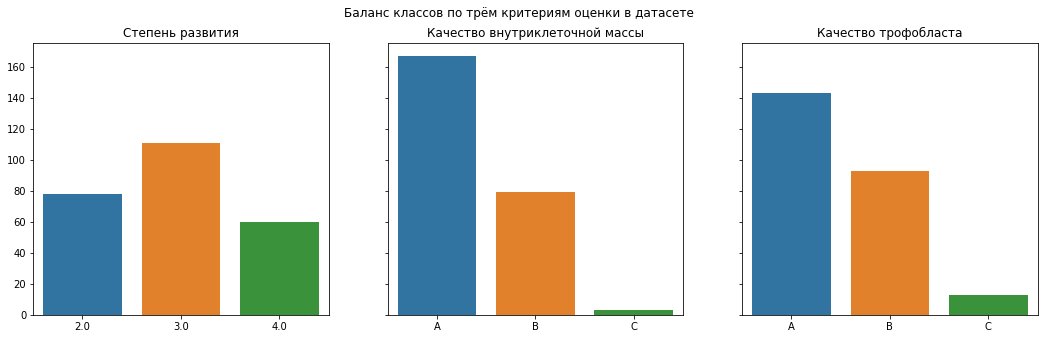

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,5), sharey=True)
cols = ['Expansion', 'ICM', 'TE']
messages = ['Степень развития',
            'Качество внутриклеточной массы',
            'Качество трофобласта']
plt.suptitle('Баланс классов по трём критериям оценки в датасете')
for i, col in enumerate(cols):
    values = df[col].value_counts()
    print(values)
    sns.barplot(y = values.values, x = values.index, ax=ax[i])
    ax[i].set_title(messages[i])

In [ ]:
weights = []
for i, col in enumerate(cols):
    vals = df[col].value_counts().values
    col_weights = []
    for val in vals:
        col_weights.append(sum(vals) / val)
    weights.append(col_weights)
weights = torch.Tensor(weights)
weights

tensor([[ 2.2432,  3.1923,  4.1500],
        [ 1.4910,  3.1519, 83.0000],
        [ 1.7413,  2.6774, 19.1538]])

In [ ]:
kfold = KFold(n_splits=params['folds'], shuffle=False)
metrics_by_fold = {}

split = list(enumerate(kfold.split(train_dataset)))
for fold, (train_ids, val_ids) in split:
    print(f'---FOLD {fold + 1}---')
    xception_model = timm.create_model('xception', pretrained=True)
    model = CompositeModel(xception_model)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], sampler=train_subsampler)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], sampler=val_subsampler)
    criterion1 = nn.CrossEntropyLoss(weight=weights[0])
    criterion2 = nn.CrossEntropyLoss(weight=weights[1])
    criterion3 = nn.CrossEntropyLoss(weight=weights[2])
    if device.type == 'cuda':
        model = model.to(device)
        criterion1 = criterion1.to(device)
        criterion2 = criterion2.to(device)
        criterion3 = criterion3.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

    acc_avg = 0
    metrics = []
    for epoch in range(1, params["epochs"] + 1):
        train_metrics = train(train_loader, model, criterion1, criterion2, criterion3, optimizer, epoch, params)
        val_metrics = validate(val_loader, model, criterion1, criterion2, criterion3, epoch, params)
        scheduler.step(val_metrics[0])
        metrics.append({'train_metrics': train_metrics,
                        'val_metrics': val_metrics})
        if acc_avg < sum(val_metrics[1:]) / 3:
            acc_avg = sum(val_metrics[1:]) / 3
            torch.save(model.state_dict(), f"/content/drive/MyDrive/classification_model_xception_fold{fold}.pth")
            print(f'new optimum reached, average accuracy = {acc_avg}, model saved')
    metrics_by_fold[fold] = metrics
    print(f'Best validation accuracy = {acc_avg}')

---FOLD 1---


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Epoch: 1. Train.           Loss: 3.061 | Accuracy_exp: 0.525 | Accuracy_icm: 0.575 | Accuracy_troph: 0.550: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]
Epoch: 1. Validation.      Loss: 2.837 | Accuracy_exp: 0.500 | Accuracy_icm: 0.692 | Accuracy_troph: 0.404: 100%|██████████| 13/13 [00:16<00:00,  1.27s/it]


new optimum reached, average accuracy = 0.532051282051282, model saved


Epoch: 2. Train.           Loss: 2.759 | Accuracy_exp: 0.568 | Accuracy_icm: 0.660 | Accuracy_troph: 0.592: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]
Epoch: 2. Validation.      Loss: 2.581 | Accuracy_exp: 0.673 | Accuracy_icm: 0.712 | Accuracy_troph: 0.462: 100%|██████████| 13/13 [00:01<00:00,  9.53it/s]


new optimum reached, average accuracy = 0.6153846153846154, model saved


Epoch: 3. Train.           Loss: 2.505 | Accuracy_exp: 0.693 | Accuracy_icm: 0.685 | Accuracy_troph: 0.598: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]
Epoch: 3. Validation.      Loss: 2.394 | Accuracy_exp: 0.692 | Accuracy_icm: 0.712 | Accuracy_troph: 0.577: 100%|██████████| 13/13 [00:01<00:00,  9.32it/s]


new optimum reached, average accuracy = 0.6602564102564102, model saved


Epoch: 4. Train.           Loss: 2.366 | Accuracy_exp: 0.733 | Accuracy_icm: 0.678 | Accuracy_troph: 0.642: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]
Epoch: 4. Validation.      Loss: 2.292 | Accuracy_exp: 0.769 | Accuracy_icm: 0.788 | Accuracy_troph: 0.519: 100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


new optimum reached, average accuracy = 0.6923076923076924, model saved


Epoch: 5. Train.           Loss: 2.233 | Accuracy_exp: 0.770 | Accuracy_icm: 0.693 | Accuracy_troph: 0.638: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]
Epoch: 5. Validation.      Loss: 2.254 | Accuracy_exp: 0.750 | Accuracy_icm: 0.769 | Accuracy_troph: 0.654: 100%|██████████| 13/13 [00:01<00:00,  9.54it/s]


new optimum reached, average accuracy = 0.7243589743589743, model saved


Epoch: 6. Train.           Loss: 2.125 | Accuracy_exp: 0.793 | Accuracy_icm: 0.665 | Accuracy_troph: 0.690: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s]
Epoch: 6. Validation.      Loss: 2.096 | Accuracy_exp: 0.750 | Accuracy_icm: 0.731 | Accuracy_troph: 0.596: 100%|██████████| 13/13 [00:01<00:00,  9.58it/s]
Epoch: 7. Train.           Loss: 1.999 | Accuracy_exp: 0.803 | Accuracy_icm: 0.748 | Accuracy_troph: 0.695: 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]
Epoch: 7. Validation.      Loss: 2.057 | Accuracy_exp: 0.731 | Accuracy_icm: 0.827 | Accuracy_troph: 0.519: 100%|██████████| 13/13 [00:01<00:00,  9.42it/s]
Epoch: 8. Train.           Loss: 1.919 | Accuracy_exp: 0.845 | Accuracy_icm: 0.723 | Accuracy_troph: 0.683: 100%|██████████| 50/50 [00:11<00:00,  4.49it/s]
Epoch: 8. Validation.      Loss: 2.087 | Accuracy_exp: 0.788 | Accuracy_icm: 0.788 | Accuracy_troph: 0.481: 100%|██████████| 13/13 [00:01<00:00,  9.33it/s]
Epoch: 9. Train.           Loss: 1.817 | Accuracy_exp: 0.853 | A

new optimum reached, average accuracy = 0.7307692307692308, model saved


Epoch: 10. Train.           Loss: 1.873 | Accuracy_exp: 0.805 | Accuracy_icm: 0.768 | Accuracy_troph: 0.740: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]
Epoch: 10. Validation.      Loss: 2.116 | Accuracy_exp: 0.750 | Accuracy_icm: 0.808 | Accuracy_troph: 0.423: 100%|██████████| 13/13 [00:01<00:00,  9.23it/s]
Epoch: 11. Train.           Loss: 1.687 | Accuracy_exp: 0.850 | Accuracy_icm: 0.797 | Accuracy_troph: 0.718: 100%|██████████| 50/50 [00:11<00:00,  4.44it/s]
Epoch: 11. Validation.      Loss: 2.157 | Accuracy_exp: 0.788 | Accuracy_icm: 0.750 | Accuracy_troph: 0.462: 100%|██████████| 13/13 [00:01<00:00,  9.26it/s]
Epoch: 12. Train.           Loss: 1.603 | Accuracy_exp: 0.825 | Accuracy_icm: 0.780 | Accuracy_troph: 0.757: 100%|██████████| 50/50 [00:11<00:00,  4.45it/s]
Epoch: 12. Validation.      Loss: 1.940 | Accuracy_exp: 0.788 | Accuracy_icm: 0.865 | Accuracy_troph: 0.673: 100%|██████████| 13/13 [00:01<00:00,  9.44it/s]


new optimum reached, average accuracy = 0.7756410256410255, model saved


Epoch: 13. Train.           Loss: 1.653 | Accuracy_exp: 0.823 | Accuracy_icm: 0.785 | Accuracy_troph: 0.748: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s]
Epoch: 13. Validation.      Loss: 2.125 | Accuracy_exp: 0.750 | Accuracy_icm: 0.808 | Accuracy_troph: 0.500: 100%|██████████| 13/13 [00:01<00:00,  9.13it/s]
Epoch: 14. Train.           Loss: 1.510 | Accuracy_exp: 0.870 | Accuracy_icm: 0.820 | Accuracy_troph: 0.778: 100%|██████████| 50/50 [00:11<00:00,  4.43it/s]
Epoch: 14. Validation.      Loss: 2.026 | Accuracy_exp: 0.769 | Accuracy_icm: 0.808 | Accuracy_troph: 0.558: 100%|██████████| 13/13 [00:01<00:00,  9.54it/s]
Epoch: 15. Train.           Loss: 1.385 | Accuracy_exp: 0.848 | Accuracy_icm: 0.875 | Accuracy_troph: 0.790: 100%|██████████| 50/50 [00:11<00:00,  4.52it/s]
Epoch: 15. Validation.      Loss: 2.120 | Accuracy_exp: 0.673 | Accuracy_icm: 0.788 | Accuracy_troph: 0.481: 100%|██████████| 13/13 [00:01<00:00,  9.63it/s]
Epoch: 16. Train.           Loss: 1.361 | Accuracy_exp: 0.

Best validation accuracy = 0.7756410256410255
---FOLD 2---


Epoch: 1. Train.           Loss: 3.077 | Accuracy_exp: 0.527 | Accuracy_icm: 0.530 | Accuracy_troph: 0.508: 100%|██████████| 50/50 [00:11<00:00,  4.46it/s]
Epoch: 1. Validation.      Loss: 2.940 | Accuracy_exp: 0.596 | Accuracy_icm: 0.577 | Accuracy_troph: 0.596: 100%|██████████| 13/13 [00:01<00:00,  9.37it/s]


new optimum reached, average accuracy = 0.5897435897435898, model saved


Epoch: 2. Train.           Loss: 2.740 | Accuracy_exp: 0.598 | Accuracy_icm: 0.688 | Accuracy_troph: 0.585: 100%|██████████| 50/50 [00:11<00:00,  4.36it/s]
Epoch: 2. Validation.      Loss: 2.672 | Accuracy_exp: 0.635 | Accuracy_icm: 0.635 | Accuracy_troph: 0.577: 100%|██████████| 13/13 [00:01<00:00,  9.44it/s]


new optimum reached, average accuracy = 0.6153846153846153, model saved


Epoch: 3. Train.           Loss: 2.519 | Accuracy_exp: 0.660 | Accuracy_icm: 0.725 | Accuracy_troph: 0.595: 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]
Epoch: 3. Validation.      Loss: 2.531 | Accuracy_exp: 0.769 | Accuracy_icm: 0.673 | Accuracy_troph: 0.558: 100%|██████████| 13/13 [00:01<00:00,  9.31it/s]


new optimum reached, average accuracy = 0.6666666666666666, model saved


Epoch: 4. Train.           Loss: 2.363 | Accuracy_exp: 0.722 | Accuracy_icm: 0.743 | Accuracy_troph: 0.663: 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]
Epoch: 4. Validation.      Loss: 2.330 | Accuracy_exp: 0.673 | Accuracy_icm: 0.654 | Accuracy_troph: 0.635: 100%|██████████| 13/13 [00:01<00:00,  9.47it/s]
Epoch: 5. Train.           Loss: 2.145 | Accuracy_exp: 0.798 | Accuracy_icm: 0.763 | Accuracy_troph: 0.653: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]
Epoch: 5. Validation.      Loss: 2.313 | Accuracy_exp: 0.808 | Accuracy_icm: 0.692 | Accuracy_troph: 0.635: 100%|██████████| 13/13 [00:01<00:00,  9.45it/s]


new optimum reached, average accuracy = 0.7115384615384616, model saved


Epoch: 6. Train.           Loss: 2.146 | Accuracy_exp: 0.735 | Accuracy_icm: 0.785 | Accuracy_troph: 0.663: 100%|██████████| 50/50 [00:11<00:00,  4.34it/s]
Epoch: 6. Validation.      Loss: 2.228 | Accuracy_exp: 0.731 | Accuracy_icm: 0.673 | Accuracy_troph: 0.654: 100%|██████████| 13/13 [00:01<00:00,  9.35it/s]
Epoch: 7. Train.           Loss: 1.952 | Accuracy_exp: 0.785 | Accuracy_icm: 0.718 | Accuracy_troph: 0.703: 100%|██████████| 50/50 [00:11<00:00,  4.44it/s]
Epoch: 7. Validation.      Loss: 2.167 | Accuracy_exp: 0.712 | Accuracy_icm: 0.712 | Accuracy_troph: 0.654: 100%|██████████| 13/13 [00:01<00:00,  9.67it/s]
Epoch: 8. Train.           Loss: 1.913 | Accuracy_exp: 0.815 | Accuracy_icm: 0.733 | Accuracy_troph: 0.657: 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]
Epoch: 8. Validation.      Loss: 2.143 | Accuracy_exp: 0.769 | Accuracy_icm: 0.635 | Accuracy_troph: 0.673: 100%|██████████| 13/13 [00:01<00:00,  9.75it/s]
Epoch: 9. Train.           Loss: 1.785 | Accuracy_exp: 0.827 | A

new optimum reached, average accuracy = 0.7948717948717948, model saved


Epoch: 10. Train.           Loss: 1.741 | Accuracy_exp: 0.850 | Accuracy_icm: 0.798 | Accuracy_troph: 0.750: 100%|██████████| 50/50 [00:11<00:00,  4.37it/s]
Epoch: 10. Validation.      Loss: 1.978 | Accuracy_exp: 0.769 | Accuracy_icm: 0.731 | Accuracy_troph: 0.673: 100%|██████████| 13/13 [00:01<00:00,  9.50it/s]
Epoch: 11. Train.           Loss: 1.635 | Accuracy_exp: 0.898 | Accuracy_icm: 0.768 | Accuracy_troph: 0.760: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]
Epoch: 11. Validation.      Loss: 2.198 | Accuracy_exp: 0.904 | Accuracy_icm: 0.731 | Accuracy_troph: 0.635: 100%|██████████| 13/13 [00:01<00:00,  9.49it/s]
Epoch: 12. Train.           Loss: 1.541 | Accuracy_exp: 0.890 | Accuracy_icm: 0.797 | Accuracy_troph: 0.747: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]
Epoch: 12. Validation.      Loss: 2.108 | Accuracy_exp: 0.885 | Accuracy_icm: 0.654 | Accuracy_troph: 0.712: 100%|██████████| 13/13 [00:01<00:00,  9.23it/s]
Epoch: 13. Train.           Loss: 1.538 | Accuracy_exp: 0.

Best validation accuracy = 0.7948717948717948
---FOLD 3---


Epoch: 1. Train.           Loss: 3.060 | Accuracy_exp: 0.485 | Accuracy_icm: 0.527 | Accuracy_troph: 0.558: 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]
Epoch: 1. Validation.      Loss: 2.888 | Accuracy_exp: 0.442 | Accuracy_icm: 0.673 | Accuracy_troph: 0.596: 100%|██████████| 13/13 [00:01<00:00,  9.60it/s]


new optimum reached, average accuracy = 0.5705128205128206, model saved


Epoch: 2. Train.           Loss: 2.696 | Accuracy_exp: 0.595 | Accuracy_icm: 0.682 | Accuracy_troph: 0.660: 100%|██████████| 50/50 [00:11<00:00,  4.50it/s]
Epoch: 2. Validation.      Loss: 2.688 | Accuracy_exp: 0.558 | Accuracy_icm: 0.673 | Accuracy_troph: 0.615: 100%|██████████| 13/13 [00:01<00:00,  9.51it/s]


new optimum reached, average accuracy = 0.6153846153846154, model saved


Epoch: 3. Train.           Loss: 2.475 | Accuracy_exp: 0.673 | Accuracy_icm: 0.700 | Accuracy_troph: 0.628: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]
Epoch: 3. Validation.      Loss: 2.508 | Accuracy_exp: 0.827 | Accuracy_icm: 0.654 | Accuracy_troph: 0.615: 100%|██████████| 13/13 [00:01<00:00,  9.34it/s]


new optimum reached, average accuracy = 0.6987179487179488, model saved


Epoch: 4. Train.           Loss: 2.292 | Accuracy_exp: 0.743 | Accuracy_icm: 0.688 | Accuracy_troph: 0.675: 100%|██████████| 50/50 [00:11<00:00,  4.43it/s]
Epoch: 4. Validation.      Loss: 2.421 | Accuracy_exp: 0.788 | Accuracy_icm: 0.635 | Accuracy_troph: 0.577: 100%|██████████| 13/13 [00:01<00:00,  9.29it/s]
Epoch: 5. Train.           Loss: 2.184 | Accuracy_exp: 0.753 | Accuracy_icm: 0.693 | Accuracy_troph: 0.673: 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]
Epoch: 5. Validation.      Loss: 2.403 | Accuracy_exp: 0.712 | Accuracy_icm: 0.577 | Accuracy_troph: 0.596: 100%|██████████| 13/13 [00:01<00:00,  9.45it/s]
Epoch: 6. Train.           Loss: 2.116 | Accuracy_exp: 0.730 | Accuracy_icm: 0.790 | Accuracy_troph: 0.663: 100%|██████████| 50/50 [00:11<00:00,  4.49it/s]
Epoch: 6. Validation.      Loss: 2.428 | Accuracy_exp: 0.731 | Accuracy_icm: 0.577 | Accuracy_troph: 0.615: 100%|██████████| 13/13 [00:01<00:00,  9.49it/s]
Epoch: 7. Train.           Loss: 1.866 | Accuracy_exp: 0.818 | A

new optimum reached, average accuracy = 0.7051282051282052, model saved


Epoch: 13. Train.           Loss: 1.317 | Accuracy_exp: 0.885 | Accuracy_icm: 0.868 | Accuracy_troph: 0.823: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]
Epoch: 13. Validation.      Loss: 2.259 | Accuracy_exp: 0.808 | Accuracy_icm: 0.654 | Accuracy_troph: 0.635: 100%|██████████| 13/13 [00:01<00:00,  9.60it/s]
Epoch: 14. Train.           Loss: 1.356 | Accuracy_exp: 0.835 | Accuracy_icm: 0.877 | Accuracy_troph: 0.810: 100%|██████████| 50/50 [00:11<00:00,  4.51it/s]
Epoch: 14. Validation.      Loss: 2.378 | Accuracy_exp: 0.808 | Accuracy_icm: 0.596 | Accuracy_troph: 0.558: 100%|██████████| 13/13 [00:01<00:00,  9.56it/s]
Epoch: 15. Train.           Loss: 1.291 | Accuracy_exp: 0.830 | Accuracy_icm: 0.865 | Accuracy_troph: 0.848: 100%|██████████| 50/50 [00:11<00:00,  4.51it/s]
Epoch: 15. Validation.      Loss: 2.152 | Accuracy_exp: 0.827 | Accuracy_icm: 0.692 | Accuracy_troph: 0.712: 100%|██████████| 13/13 [00:01<00:00,  9.52it/s]


new optimum reached, average accuracy = 0.7435897435897436, model saved


Epoch: 16. Train.           Loss: 1.276 | Accuracy_exp: 0.848 | Accuracy_icm: 0.883 | Accuracy_troph: 0.858: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]
Epoch: 16. Validation.      Loss: 2.437 | Accuracy_exp: 0.865 | Accuracy_icm: 0.596 | Accuracy_troph: 0.635: 100%|██████████| 13/13 [00:01<00:00,  9.47it/s]
Epoch: 17. Train.           Loss: 1.215 | Accuracy_exp: 0.853 | Accuracy_icm: 0.895 | Accuracy_troph: 0.845: 100%|██████████| 50/50 [00:11<00:00,  4.30it/s]
Epoch: 17. Validation.      Loss: 2.482 | Accuracy_exp: 0.865 | Accuracy_icm: 0.558 | Accuracy_troph: 0.596: 100%|██████████| 13/13 [00:01<00:00,  9.52it/s]
Epoch: 18. Train.           Loss: 1.081 | Accuracy_exp: 0.912 | Accuracy_icm: 0.900 | Accuracy_troph: 0.850: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s]
Epoch: 18. Validation.      Loss: 2.523 | Accuracy_exp: 0.769 | Accuracy_icm: 0.692 | Accuracy_troph: 0.615: 100%|██████████| 13/13 [00:01<00:00,  9.55it/s]
Epoch: 19. Train.           Loss: 1.154 | Accuracy_exp: 0.

Best validation accuracy = 0.7435897435897436
---FOLD 4---


Epoch: 1. Train.           Loss: 3.091 | Accuracy_exp: 0.423 | Accuracy_icm: 0.625 | Accuracy_troph: 0.487: 100%|██████████| 50/50 [00:11<00:00,  4.45it/s]
Epoch: 1. Validation.      Loss: 2.962 | Accuracy_exp: 0.462 | Accuracy_icm: 0.635 | Accuracy_troph: 0.481: 100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


new optimum reached, average accuracy = 0.5256410256410257, model saved


Epoch: 2. Train.           Loss: 2.680 | Accuracy_exp: 0.580 | Accuracy_icm: 0.703 | Accuracy_troph: 0.588: 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]
Epoch: 2. Validation.      Loss: 2.748 | Accuracy_exp: 0.788 | Accuracy_icm: 0.577 | Accuracy_troph: 0.519: 100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


new optimum reached, average accuracy = 0.6282051282051282, model saved


Epoch: 3. Train.           Loss: 2.436 | Accuracy_exp: 0.657 | Accuracy_icm: 0.723 | Accuracy_troph: 0.643: 100%|██████████| 50/50 [00:11<00:00,  4.39it/s]
Epoch: 3. Validation.      Loss: 2.496 | Accuracy_exp: 0.788 | Accuracy_icm: 0.654 | Accuracy_troph: 0.538: 100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


new optimum reached, average accuracy = 0.6602564102564102, model saved


Epoch: 4. Train.           Loss: 2.247 | Accuracy_exp: 0.737 | Accuracy_icm: 0.723 | Accuracy_troph: 0.680: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s]
Epoch: 4. Validation.      Loss: 2.392 | Accuracy_exp: 0.865 | Accuracy_icm: 0.712 | Accuracy_troph: 0.538: 100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


new optimum reached, average accuracy = 0.7051282051282052, model saved


Epoch: 5. Train.           Loss: 2.134 | Accuracy_exp: 0.760 | Accuracy_icm: 0.757 | Accuracy_troph: 0.643: 100%|██████████| 50/50 [00:11<00:00,  4.36it/s]
Epoch: 5. Validation.      Loss: 2.341 | Accuracy_exp: 0.846 | Accuracy_icm: 0.692 | Accuracy_troph: 0.577: 100%|██████████| 13/13 [00:01<00:00,  8.98it/s]
Epoch: 6. Train.           Loss: 1.949 | Accuracy_exp: 0.818 | Accuracy_icm: 0.755 | Accuracy_troph: 0.657: 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]
Epoch: 6. Validation.      Loss: 2.386 | Accuracy_exp: 0.750 | Accuracy_icm: 0.673 | Accuracy_troph: 0.538: 100%|██████████| 13/13 [00:01<00:00,  9.20it/s]
Epoch: 7. Train.           Loss: 1.965 | Accuracy_exp: 0.795 | Accuracy_icm: 0.747 | Accuracy_troph: 0.685: 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]
Epoch: 7. Validation.      Loss: 2.134 | Accuracy_exp: 0.885 | Accuracy_icm: 0.808 | Accuracy_troph: 0.596: 100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


new optimum reached, average accuracy = 0.7628205128205128, model saved


Epoch: 8. Train.           Loss: 1.873 | Accuracy_exp: 0.828 | Accuracy_icm: 0.747 | Accuracy_troph: 0.665: 100%|██████████| 50/50 [00:11<00:00,  4.36it/s]
Epoch: 8. Validation.      Loss: 2.204 | Accuracy_exp: 0.846 | Accuracy_icm: 0.827 | Accuracy_troph: 0.538: 100%|██████████| 13/13 [00:01<00:00,  9.10it/s]
Epoch: 9. Train.           Loss: 1.753 | Accuracy_exp: 0.807 | Accuracy_icm: 0.813 | Accuracy_troph: 0.737: 100%|██████████| 50/50 [00:11<00:00,  4.46it/s]
Epoch: 9. Validation.      Loss: 2.256 | Accuracy_exp: 0.846 | Accuracy_icm: 0.750 | Accuracy_troph: 0.577: 100%|██████████| 13/13 [00:01<00:00,  9.21it/s]
Epoch: 10. Train.           Loss: 1.608 | Accuracy_exp: 0.830 | Accuracy_icm: 0.798 | Accuracy_troph: 0.770: 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]
Epoch: 10. Validation.      Loss: 2.249 | Accuracy_exp: 0.827 | Accuracy_icm: 0.731 | Accuracy_troph: 0.519: 100%|██████████| 13/13 [00:01<00:00,  9.21it/s]
Epoch: 11. Train.           Loss: 1.499 | Accuracy_exp: 0.888 

Best validation accuracy = 0.7628205128205128
---FOLD 5---


Epoch: 1. Train.           Loss: 3.082 | Accuracy_exp: 0.415 | Accuracy_icm: 0.595 | Accuracy_troph: 0.425: 100%|██████████| 50/50 [00:11<00:00,  4.41it/s]
Epoch: 1. Validation.      Loss: 2.831 | Accuracy_exp: 0.519 | Accuracy_icm: 0.731 | Accuracy_troph: 0.615: 100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


new optimum reached, average accuracy = 0.6217948717948718, model saved


Epoch: 2. Train.           Loss: 2.711 | Accuracy_exp: 0.625 | Accuracy_icm: 0.670 | Accuracy_troph: 0.565: 100%|██████████| 50/50 [00:11<00:00,  4.35it/s]
Epoch: 2. Validation.      Loss: 2.480 | Accuracy_exp: 0.904 | Accuracy_icm: 0.596 | Accuracy_troph: 0.519: 100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


new optimum reached, average accuracy = 0.673076923076923, model saved


Epoch: 3. Train.           Loss: 2.484 | Accuracy_exp: 0.690 | Accuracy_icm: 0.700 | Accuracy_troph: 0.635: 100%|██████████| 50/50 [00:11<00:00,  4.29it/s]
Epoch: 3. Validation.      Loss: 2.358 | Accuracy_exp: 0.904 | Accuracy_icm: 0.615 | Accuracy_troph: 0.558: 100%|██████████| 13/13 [00:01<00:00,  9.37it/s]


new optimum reached, average accuracy = 0.6923076923076922, model saved


Epoch: 4. Train.           Loss: 2.215 | Accuracy_exp: 0.785 | Accuracy_icm: 0.675 | Accuracy_troph: 0.640: 100%|██████████| 50/50 [00:11<00:00,  4.35it/s]
Epoch: 4. Validation.      Loss: 2.173 | Accuracy_exp: 0.904 | Accuracy_icm: 0.519 | Accuracy_troph: 0.500: 100%|██████████| 13/13 [00:01<00:00,  9.18it/s]
Epoch: 5. Train.           Loss: 2.169 | Accuracy_exp: 0.755 | Accuracy_icm: 0.705 | Accuracy_troph: 0.605: 100%|██████████| 50/50 [00:11<00:00,  4.45it/s]
Epoch: 5. Validation.      Loss: 2.132 | Accuracy_exp: 0.904 | Accuracy_icm: 0.577 | Accuracy_troph: 0.577: 100%|██████████| 13/13 [00:01<00:00,  9.29it/s]
Epoch: 6. Train.           Loss: 2.096 | Accuracy_exp: 0.745 | Accuracy_icm: 0.760 | Accuracy_troph: 0.670: 100%|██████████| 50/50 [00:11<00:00,  4.43it/s]
Epoch: 6. Validation.      Loss: 1.972 | Accuracy_exp: 0.827 | Accuracy_icm: 0.788 | Accuracy_troph: 0.654: 100%|██████████| 13/13 [00:01<00:00,  9.59it/s]


new optimum reached, average accuracy = 0.7564102564102564, model saved


Epoch: 7. Train.           Loss: 1.925 | Accuracy_exp: 0.830 | Accuracy_icm: 0.790 | Accuracy_troph: 0.660: 100%|██████████| 50/50 [00:11<00:00,  4.36it/s]
Epoch: 7. Validation.      Loss: 1.897 | Accuracy_exp: 0.904 | Accuracy_icm: 0.654 | Accuracy_troph: 0.635: 100%|██████████| 13/13 [00:01<00:00,  9.17it/s]
Epoch: 8. Train.           Loss: 1.871 | Accuracy_exp: 0.785 | Accuracy_icm: 0.730 | Accuracy_troph: 0.680: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s]
Epoch: 8. Validation.      Loss: 1.931 | Accuracy_exp: 0.904 | Accuracy_icm: 0.577 | Accuracy_troph: 0.596: 100%|██████████| 13/13 [00:01<00:00,  9.29it/s]
Epoch: 9. Train.           Loss: 1.706 | Accuracy_exp: 0.810 | Accuracy_icm: 0.765 | Accuracy_troph: 0.750: 100%|██████████| 50/50 [00:11<00:00,  4.45it/s]
Epoch: 9. Validation.      Loss: 1.903 | Accuracy_exp: 0.808 | Accuracy_icm: 0.654 | Accuracy_troph: 0.692: 100%|██████████| 13/13 [00:01<00:00,  9.42it/s]
Epoch: 10. Train.           Loss: 1.752 | Accuracy_exp: 0.825 | 

new optimum reached, average accuracy = 0.794871794871795, model saved


Epoch: 13. Train.           Loss: 1.400 | Accuracy_exp: 0.845 | Accuracy_icm: 0.845 | Accuracy_troph: 0.805: 100%|██████████| 50/50 [00:11<00:00,  4.33it/s]
Epoch: 13. Validation.      Loss: 1.882 | Accuracy_exp: 0.865 | Accuracy_icm: 0.769 | Accuracy_troph: 0.462: 100%|██████████| 13/13 [00:01<00:00,  9.34it/s]
Epoch: 14. Train.           Loss: 1.387 | Accuracy_exp: 0.890 | Accuracy_icm: 0.810 | Accuracy_troph: 0.785: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]
Epoch: 14. Validation.      Loss: 1.752 | Accuracy_exp: 0.904 | Accuracy_icm: 0.808 | Accuracy_troph: 0.596: 100%|██████████| 13/13 [00:01<00:00,  9.34it/s]
Epoch: 15. Train.           Loss: 1.283 | Accuracy_exp: 0.875 | Accuracy_icm: 0.890 | Accuracy_troph: 0.825: 100%|██████████| 50/50 [00:11<00:00,  4.46it/s]
Epoch: 15. Validation.      Loss: 1.678 | Accuracy_exp: 0.904 | Accuracy_icm: 0.750 | Accuracy_troph: 0.654: 100%|██████████| 13/13 [00:01<00:00,  9.53it/s]
Epoch: 16. Train.           Loss: 1.277 | Accuracy_exp: 0.

new optimum reached, average accuracy = 0.814102564102564, model saved


Epoch: 17. Train.           Loss: 1.160 | Accuracy_exp: 0.905 | Accuracy_icm: 0.860 | Accuracy_troph: 0.810: 100%|██████████| 50/50 [00:11<00:00,  4.33it/s]
Epoch: 17. Validation.      Loss: 1.754 | Accuracy_exp: 0.904 | Accuracy_icm: 0.654 | Accuracy_troph: 0.750: 100%|██████████| 13/13 [00:01<00:00,  9.44it/s]
Epoch: 18. Train.           Loss: 1.178 | Accuracy_exp: 0.870 | Accuracy_icm: 0.840 | Accuracy_troph: 0.880: 100%|██████████| 50/50 [00:11<00:00,  4.43it/s]
Epoch: 18. Validation.      Loss: 1.900 | Accuracy_exp: 0.846 | Accuracy_icm: 0.635 | Accuracy_troph: 0.635: 100%|██████████| 13/13 [00:01<00:00,  9.45it/s]
Epoch: 19. Train.           Loss: 1.152 | Accuracy_exp: 0.890 | Accuracy_icm: 0.855 | Accuracy_troph: 0.855: 100%|██████████| 50/50 [00:11<00:00,  4.46it/s]
Epoch: 19. Validation.      Loss: 1.739 | Accuracy_exp: 0.923 | Accuracy_icm: 0.731 | Accuracy_troph: 0.712: 100%|██████████| 13/13 [00:01<00:00,  9.36it/s]
Epoch: 20. Train.           Loss: 1.110 | Accuracy_exp: 0.

Best validation accuracy = 0.814102564102564


In [ ]:
def find_best_epoch(metrics_by_fold):
    folds = metrics_by_fold.keys()
    epochs = [999] * len(metrics_by_fold.keys())
    res = dict(zip(folds, epochs))
    for fold in metrics_by_fold.keys():
        best_pos = 0
        best_val = 999
        for i, epoch in enumerate(metrics_by_fold[fold]):
            if epoch['val_metrics'][0] < best_val:
                best_pos = i
                best_val = epoch['val_metrics'][0]
                res[fold] = best_pos
    return res

best_epochs = find_best_epoch(metrics_by_fold)
print(best_epochs)

def find_avg_accuracies(metrics_by_fold, best_epochs):
    accs = []
    for i in range(1, 4):
        acc = 0
        for fold in metrics_by_fold.keys():
            fold_acc = metrics_by_fold[fold][best_epochs[fold]]['val_metrics'][i]
            acc += fold_acc
        acc /= len(metrics_by_fold.keys())
        accs.append(acc)
    return accs

print(find_avg_accuracies(metrics_by_fold, best_epochs))

def avg_metric_by_epoch(metrics_by_fold, train=True):
    res = {'loss': [],
        'avg_exp': [],
            'avg_icm': [],
            'avg_te': []}
    metrics_set = 'train_metrics' if train else 'val_metrics'

    for epoch in range(params['epochs']):
        for i, metric in enumerate(res.keys()):
            metric_avg = 0
            for fold in metrics_by_fold.keys():
                metric_avg += metrics_by_fold[fold][epoch][metrics_set][i]
            metric_avg /= len(metrics_by_fold.keys())
            res[metric].append(metric_avg)

    return res
train_loss_avg = avg_metric_by_epoch(metrics_by_fold, train=True)['loss']
val_loss_avg = avg_metric_by_epoch(metrics_by_fold, train=False)['loss']


{0: 11, 1: 9, 2: 14, 3: 10, 4: 14}
[0.8346153846153846, 0.7346153846153846, 0.6576923076923078]


In [ ]:
model.load_state_dict(torch.load(f"/content/drive/MyDrive/classification_model_xception_fold{fold}.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

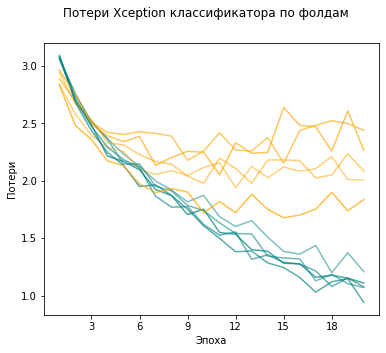

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_losses(train_loss, val_loss, ax, i=0):
    # ax.set_title(f'Потери по {i + 1} фолду')
    epochs = range(1, len(train_loss) + 1)
    sns.lineplot(x=epochs, y=train_loss, label='Потери при тренировке', ax=ax, color='teal', alpha=0.5 + i/20)
    sns.lineplot(x=epochs, y=val_loss, label='Потери при валидации', ax=ax, color='orange', alpha=0.5 + i/20)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(xlabel='Эпоха', ylabel='Потери')
    # plt.xlabel('Эпоха')
    # plt.ylabel('Потери')
    ax.get_legend().remove()
# plot_losses(train_loss_avg, val_loss_avg)

def plot_losses_by_fold():
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    for i, fold in enumerate(metrics_by_fold.keys()):
        train_loss = [x['train_metrics'][0] for x in metrics_by_fold[fold]]
        val_loss = [x['val_metrics'][0] for x in metrics_by_fold[fold]]
        plot_losses(train_loss, val_loss, ax=ax, i=i)
    plt.suptitle('Потери Xception классификатора по фолдам')
plot_losses_by_fold()

---FOLD 1---


100%|██████████| 13/13 [00:01<00:00,  9.35it/s]


---FOLD 2---


100%|██████████| 13/13 [00:01<00:00,  9.90it/s]


---FOLD 3---


100%|██████████| 13/13 [00:01<00:00,  9.50it/s]


---FOLD 4---


100%|██████████| 13/13 [00:01<00:00,  9.44it/s]


---FOLD 5---


100%|██████████| 13/13 [00:01<00:00,  9.72it/s]


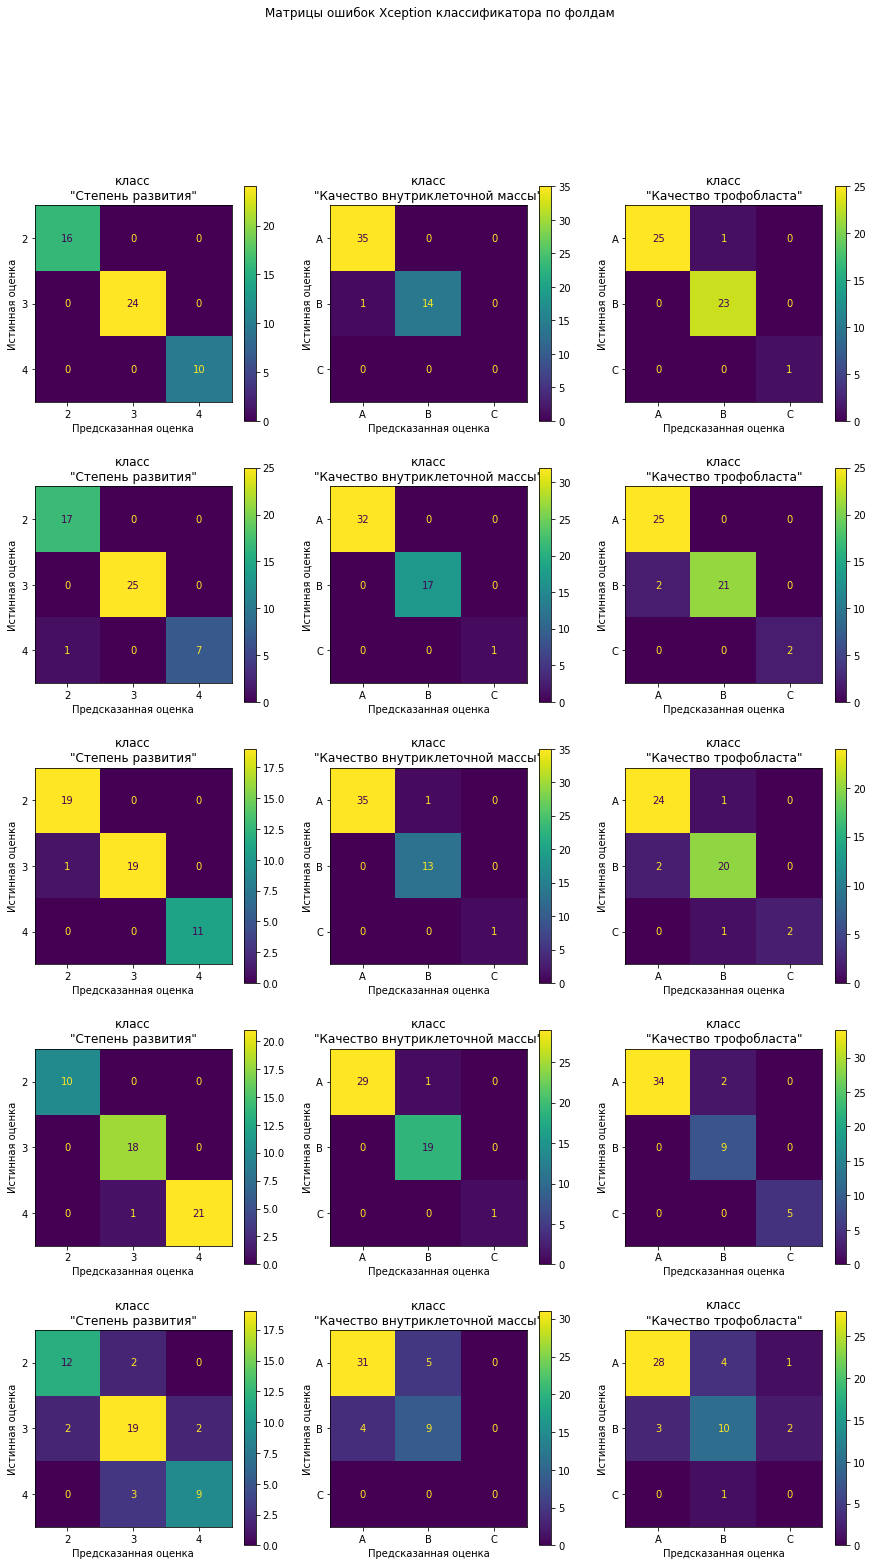

In [ ]:
def plot_confusion_matrices(loader, ax):
    n_classes = 3
    classes_numbered = [2, 3, 4]
    classes_lettered = ['A', 'B', 'C']
    # fig, ax = plt.subplots(1,3, figsize=(15,5))

    matrices = torch.zeros(3, n_classes, n_classes)
    messages = ['класс\n"Степень развития"',
                'класс\n"Качество внутриклеточной массы"',
                'класс\n"Качество трофобласта"']
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            labels = labels.to(device)
            results = model(images)

            for i, matrix in enumerate(matrices):
                for t, p in zip(torch.max(results[i], 1).indices.view(-1), labels[:, i].view(-1)):
                    matrix[t.long(), p.long()] += 1

        for i, matrix in enumerate(matrices):
            classes = classes_numbered if i==0 else classes_lettered
            disp_exp = ConfusionMatrixDisplay(confusion_matrix=matrix.numpy(), display_labels=classes)
            disp_exp.plot(ax=ax[i])
            ax[i].set_title(f'{messages[i]}')
            ax[i].set(xlabel='Предсказанная оценка', ylabel='Истинная оценка')
    

def plot_conf_matrices_by_fold(split):
    fig, ax = plt.subplots(params['folds'], 3, figsize=(15, params['folds'] * 5))
    for fold, (train_ids, val_ids) in split:
        print(f'---FOLD {fold + 1}---')
        xception_model = timm.create_model('xception', pretrained=True)
        model = CompositeModel(xception_model)
        model.load_state_dict(torch.load(f"/content/drive/MyDrive/classification_model_xception_fold{fold}.pth", map_location=torch.device('cpu')))
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], sampler=val_subsampler)
        plot_confusion_matrices(val_loader, ax[fold])
    fig.suptitle('Матрицы ошибок Xception классификатора по фолдам')

plot_conf_matrices_by_fold(split)